Basic api for general data: https://www.blockchain.com/ru/api/q
Blockchain data api: https://www.blockchain.com/ru/api/blockchain_api
Mempool api: https://mempool.space/docs/api/rest#get-blocks

TODO:
1) Вийняти з отсанніх 5 блоків транзакцій з такою самою комісію +-0.5 сатоши (можливо з хожим розміром). Порахувати час прийняття кожної транзакції. Вибудувати розподіл
2) Побудувати розподіл часу підтвердження останніх транзакцій з такою самою комісією

GET /api/v1/mining/blocks/sizes-weights/:timePeriod
Максимальна вага блоку - 4 мільонів weights
Оцінювати потрібно два основних джерела даних:
1) Мемпул (непідтверджені транзакції):
* Кількість транзакцій (краще оцінювати weight)
* Розподіл по комісії
* Розмір транзакцій
* Часовий лок
2) Блокчейн (підтвержені транзакції)
* Частота майнингу блоку
* Комісії минулих блоків (враховувати weight)

Думки:
У транзакції потрібно оцінювати лише віртуальний розмір (вага / 4) і комісію за траназкцію (загальна комісія на вБайти)

По ідеї виставити можна і менше ніж 1 сатоші за вБайт, але іще ні одну транзакцію я таку не бачив (у транзакції записується загальна сума за транзакцію, а не сатоші за вБайт)

Немає сенсу дивитися швидкість прийняття транзакцій у останніх блоках, так як їх може бути мало

Є сенс оцінити мем пул, частоту появи і заповненість останніх блоків та  

ОЦІНКА МЕМПУЛУ
У ПЕРШУ ЧЕРГУ ПОТРІБНО ВИЗНАЧИТИСЯ У ЯКИЙ БЛОК ПОТРАПИТЬ ТРАНЗАКЦІЯ (У ПЕРШИЙ, У ДРУГИЙ, У ТРЕТІЙ І ТД)
це можна отримати, оцінюючи мемпул і кількість транзакцій у ньому, тобто перед цією транзакцію
Як відбувається відбір:
Перша черга - транзакції з найбільшою комісією і з найменшим розміром
Друга черга - транзкації з такою самою комісією і з більшим розміром

Таким чином оцінити, де +- буде знаходитися транзакція 

Дістати мемпул, дістати транзакції з мемпулу, відсортувати по комісії і розміру, розрахувати, де приблизно буде транзакція (шанс потрапляння у конкретний блок)

ОЦІНКА БЛОКЧЕЙНУ
Дістати транзакції за потрібний відрізок часу (останній 1 блок, останні 2 блоки, останні 10 блоків) і тд, порахувати загальну кількість ваги у кожному блоці та яку частину з цієї ваги наша транзакція була б кращою за інші (або такою самою)

Як варіант виймати статистику останніх декількох місяців та за допомогою регресії робити оцінку

Чи потрапить транзакція у наступний блок?
Максимальна вага блоку - 4 мільони вБайтів
Можна брати мемпул, оцінювати його стан

Зібрати статистику мемпулу кожні н секунд
Оцінювати номер у черзі транзакції
Взяти розподіл частоти майнингу блоків
За допомогою розподілу генерувати випадкове значення (поява нового блоку) і так оцінювати частоту розвантаження мемпулу

TODO:
Зрозуміти, як відбувається відбір транзакцій у мемпулі
Зрозуміти, як відбувається корегування системи (кожні 2016 блоків відбувається корекція)

З 2017 року використовується RBF технологія (Replace By Fee), яка може генерувати нову транзакцію схожу на непідвтреджету, щоб новою траназкцією з більшою комісією перебити стару транзакцію

In [2]:
from urllib import response
import requests
import json
import numpy as np
from numpy import sort
import seaborn as sns
import matplotlib.pyplot as plt

class Transaction:
    def __init__(self, hash, weight, lock_time, fee, mempool_time, block_time):
        self.hash = hash
        self.weight = weight
        self.lock_time = lock_time
        self.fee = fee
        self.mempool_time = mempool_time
        self.block_time = block_time

def getLastBlocksInfo(numberOfBlocks):
    NUMBER_OF_BLOCKS_PER_REQUEST = 15
    blocks = list()   
    
    lastBlockHeight = int(requests.get("https://mempool.space/api/blocks/tip/height").text)

    numberOfRequests = numberOfBlocks // NUMBER_OF_BLOCKS_PER_REQUEST
    if numberOfBlocks % NUMBER_OF_BLOCKS_PER_REQUEST != 0:
        numberOfRequests += 1

    # TODO: optimize append    
    for i in range (0, numberOfRequests):
        blocksList = requests.get("https://mempool.space/api/v1/blocks/" + str(lastBlockHeight)).json()
        for block in blocksList:
            if len(blocks) == numberOfBlocks:
                break
            blocks.append(block)
        lastBlockHeight -= NUMBER_OF_BLOCKS_PER_REQUEST

    return blocks

def getTransactionsFromBlock(blockHash):
    transactionsList = list()
    block = requests.get("https://blockchain.info/rawblock/" + blockHash).json()
    transactions = block.get('tx')
    for tx in transactions:
        transactionsList.append(Transaction(tx.get('hash'), tx.get('weight'), tx.get('lock_time'),
         tx.get('fee'), tx.get('time'), block.get('time')))
    return transactionsList

def getTransaction(tx_hash):
    tx = requests.get("https://blockchain.info/rawblock/" + tx_hash).json()
    return Transaction(tx.get('hash'), tx.get('weight'), tx.get('lock_time'),
         tx.get('fee'), tx.get('time'), -1)


Avarage time for 800 blocks: 631.78875


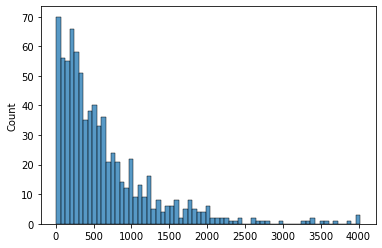

In [7]:
# DISTRIBUTION OF TIME MINING OF LAST N BLOCKS
def getTimestampsOfLastBlocks(numberOfBlocks):
    NUMBER_OF_BLOCKS_PER_REQUEST = 15
    timestamps = list()

    lastBlockHeight = int(requests.get("https://mempool.space/api/blocks/tip/height").text)

    numberOfRequests = numberOfBlocks // NUMBER_OF_BLOCKS_PER_REQUEST
    if numberOfBlocks % NUMBER_OF_BLOCKS_PER_REQUEST != 0:
        numberOfRequests += 1
    
    for i in range (0, numberOfRequests):
        blocksList = requests.get("https://mempool.space/api/v1/blocks/" + str(lastBlockHeight)).json()
        for block in blocksList:
            if len(timestamps) == numberOfBlocks:
                break
            timestamps.append(block.get('timestamp'))
        lastBlockHeight -= NUMBER_OF_BLOCKS_PER_REQUEST
    
    return timestamps

def getAvarageTimeAndHistogram(numberOfBlocks): 
    timestamps = getTimestampsOfLastBlocks(numberOfBlocks)
    timestamps.sort()
    blockMiningTime = []
    for i in range (1, len(timestamps)):
        blockMiningTime.append(timestamps[i] - timestamps[i-1])
        
    print(f"Avarage time for {numberOfBlocks} blocks: {sum(blockMiningTime) / len (timestamps)}")    
    ax = sns.histplot(data = blockMiningTime, binwidth=60)
    plt.show()

getAvarageTimeAndHistogram(800)

666 188


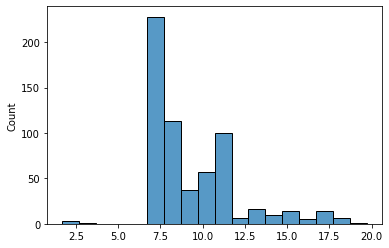

In [3]:
def getLastBlockHashes(numberOfBlocks):
    NUMBER_OF_BLOCKS_PER_REQUEST = 15
    blockHashes = list()   
    
    lastBlockHeight = int(requests.get("https://mempool.space/api/blocks/tip/height").text)

    numberOfRequests = numberOfBlocks // NUMBER_OF_BLOCKS_PER_REQUEST
    if numberOfBlocks % NUMBER_OF_BLOCKS_PER_REQUEST != 0:
        numberOfRequests += 1
        
    for i in range (0, numberOfRequests):
        blocksList = requests.get("https://mempool.space/api/v1/blocks/" + str(lastBlockHeight)).json()
        for block in blocksList:
            if len(blockHashes) == numberOfBlocks:
                break
            blockHashes.append(block.get('id'))
        lastBlockHeight -= NUMBER_OF_BLOCKS_PER_REQUEST
    return blockHashes

def getTransactionsOfLastBlocks(numberOfBlocks):
    transactionsInBlocks = list()
    blockHashes = getLastBlockHashes(numberOfBlocks)
    for blockHash in blockHashes:
        transactionsInBlocks += getTransactionsFromBlock(blockHash)
    return transactionsInBlocks

def getFilteredTransactions(transactions, minFeePerVbyte, maxFeePerVbyte):
    filteredTransactions = list()
    for tx in transactions:
        feePerVbyte = round(tx.fee / (tx.weight / 4), 2)
        if minFeePerVbyte <= feePerVbyte <= maxFeePerVbyte and tx.lock_time == 0:
            filteredTransactions.append(tx)
    return filteredTransactions

def buildDistributionOfTransactionFees(transactions):
    data = list()
    for tx in transactions:
        fee = round(tx.fee / (tx.weight / 4), 2)
        if 1 < fee < 20:
            data.append(fee)
    ax = sns.histplot(data = data, binwidth=1)
    plt.show()    

transactions = getTransactionsOfLastBlocks(1)
filteredTransactions = getFilteredTransactions(transactions, 1, 8)
print(len(transactions), len(filteredTransactions))
buildDistributionOfTransactionFees(transactions)

Код для збирання статистики з мемпулу

In [7]:
mempoolTransactionsTxids = requests.get("https://mempool.space/api/mempool/txids").json()
mempoolTransactions = list()
transactions = requests.get("https://blockchain.info/unconfirmed-transactions?format=json").json()
print(len(transactions.get('txs')))
print(len(mempoolTransactionsTxids))

'''
for txid in mempoolTransactionsTxids:
    mempoolTransactions.append(getTransaction(txid))
    print(len(mempoolTransactions))
'''

100
3710


'\nfor txid in mempoolTransactionsTxids:\n    mempoolTransactions.append(getTransaction(txid))\n    print(len(mempoolTransactions))\n'

Код для збирання даних з мемпулу

In [1]:
import threading
import requests
import json
import time

filepath = "G:\\Bitcoin_mempool_state\\"

headers = {
        'content-type': 'application/json',
    }

data = '{"jsonrpc": "1.0", "id": "curltest", "method": "getrawmempool", "params": [true]}'

def getMempoolState(iterations, waitTime):
    for i in range(0, iterations):
        response = requests.post('https://responsive-frosty-tent.bcoin.discover.quiknode.pro/67427eeafaf13fedc399dc5b124246ffce77033a/', headers=headers, data=data)
        #requests.get("https://blockchain.info/unconfirmed-transactions?format=json")
        
        with open(filepath + str(round(time.time())) + '.json', 'w', encoding='utf-8') as f:
            json.dump(response.json(), f, ensure_ascii=False, indent=4)
        print(time.strftime("%H:%M:%S") + " Mempool saved")
        time.sleep(waitTime)
        

t1 = threading.Thread(target=getMempoolState, args=(2000, 20))

def pollingForNewBlock():

    BlockHeight = requests.get("https://mempool.space/api/blocks/tip/height").json()
    
    while t1.is_alive():
        newBlockHeight = requests.get("https://mempool.space/api/blocks/tip/height").json()
        if BlockHeight != newBlockHeight:
            BlockHeight = newBlockHeight
        
            response = requests.post('https://responsive-frosty-tent.bcoin.discover.quiknode.pro/67427eeafaf13fedc399dc5b124246ffce77033a/', headers=headers, data=data)
            # requests.get("https://blockchain.info/unconfirmed-transactions?format=json")
            
            with open(filepath + str(round(time.time())) + '.json', 'w', encoding='utf-8') as f:
                json.dump(response.json(), f, ensure_ascii=False, indent=4)
            print(time.strftime("%H:%M:%S") + " Mempool saved after block mining")
        time.sleep(3)
        
t2 = threading.Thread(target = pollingForNewBlock)

t1.start()
t2.start()

t1.join()
t2.join()


20:51:06 Mempool saved


Exception in thread Thread-3 (getMempoolState):
Traceback (most recent call last):
  File "c:\Users\Bohdan\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\Bohdan\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Bohdan\AppData\Local\Temp\ipykernel_24620\203549095.py", line 19, in getMempoolState
FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Bitcoin_mempool_state\\1669920689.json'


KeyboardInterrupt: 

Код для сортування черги у мемпулі

Код для отримання приблизної комісії з мемпулу

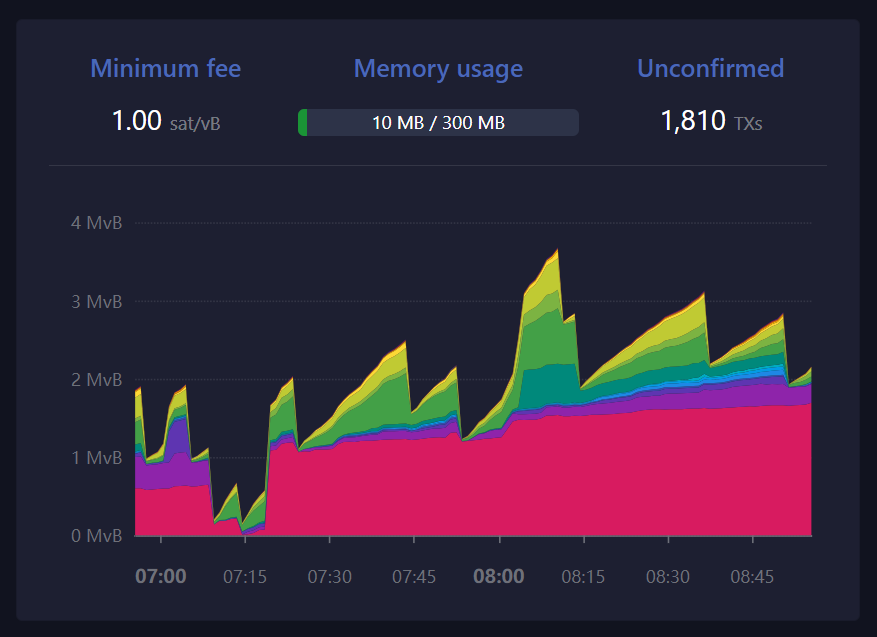

In [8]:
import requests
import json

headers = {
        'content-type': 'application/json',
    }

data = '{"jsonrpc": "1.0", "id": "curltest", "method": "estimatesmartfee", "params": [3]}'

response = requests.post('https://responsive-frosty-tent.bcoin.discover.quiknode.pro/67427eeafaf13fedc399dc5b124246ffce77033a/', headers=headers, data=data)

print(response.json())
# Estimates the approximate fee per kilobyte needed for a transaction to begin
# confirmation within conf_target blocks if possible and return the number of blocks
# for which the estimate is valid.



{'result': {'fee': 0.00035564, 'blocks': 3}, 'error': None, 'id': 'curltest'}


In [8]:
# sort by 1) More fee rate 2) More size 3) More time

542.6688
9.04448
12:40:50 +


In [19]:
# RECOMENDED FEES GIVEN BY MEMPOOL.SPACE
url = "https://mempool.space/api/v1/fees/recommended"

response = requests.get(url)
print(response.text)

{"fastestFee":22,"halfHourFee":18,"hourFee":16,"economyFee":4,"minimumFee":2}


In [ ]:
from urllib import response
import requests
import json
# get unconfirmed transactions https://blockchain.info/unconfirmed-transactions?format=json
url = "https://blockchain.info/unconfirmed-transactions?format=json"

response = requests.get(url)
data = json.loads(response.text)
print(json.dumps(data, indent = 3))

1) Моделювання росту мемпулу
Суть
Взяти мемпул на даний момент і на його основі побудувати функцію розподілу для моделювання появи нових транзакцій. 

Деталі
Запит мемпулу приходить у виглді json файлу з транзакціями, які відсортовані по часу появи. Для моделювання транзакцій не потрібно брати весь мемпул, потрібно взяти лише транзакції мемпулу за останні n секунд. У самій транзакції нас цікавить два поля - fee та weight. Таким чином появи нових транзакцій - це випадковий процес, у якого є дві випадкові змінні (fee та weight), які взаємопов'язані між собою. 

Реалізація
Взяти json мемпулу, вийняти транзакції за n секунд, побудувати розподіл fee/

1) Аналіз мемпулу

In [ ]:
import requests
import json
NODE_URL = 'https://responsive-frosty-tent.bcoin.discover.quiknode.pro/67427eeafaf13fedc399dc5b124246ffce77033a/'

headers = {
        'content-type': 'application/json',
    }

data = '{"jsonrpc": "1.0", "id": "curltest", "method": "getrawmempool", "params": [true]}'

response = requests.post(NODE_URL, headers=headers, data=data)

response.json()


